# PyTorch Object Detection and Tracking

This lab is applying YoloV3 on some images coming from the COCO dataset.

## Step 1: Download the object detection system

Download the code to run the object detection

In [1]:
%%shell

# Install pycocotools
git clone https://github.com/cfotache/pytorch_objectdetecttrack

Cloning into 'pytorch_objectdetecttrack'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36
Unpacking objects: 100% (36/36), done.


In [2]:
%ls -l
%cd pytorch_objectdetecttrack/
%ls -l

total 8
drwxr-xr-x 6 root root 4096 Mar 27 08:43 pytorch_objectdetecttrack/
drwxr-xr-x 1 root root 4096 Mar 18 16:23 sample_data/
/content/pytorch_objectdetecttrack
total 500
drwxr-xr-x 2 root root   4096 Mar 27 08:43 config/
drwxr-xr-x 2 root root   4096 Mar 27 08:43 images/
-rw-r--r-- 1 root root  14374 Mar 27 08:43 models.py
-rw-r--r-- 1 root root   3735 Mar 27 08:43 object_tracker.py
-rw-r--r-- 1 root root 451724 Mar 27 08:43 PyTorch_Object_Detection.ipynb
-rw-r--r-- 1 root root   5192 Mar 27 08:43 PyTorch_Object_Tracking.ipynb
-rw-r--r-- 1 root root    701 Mar 27 08:43 README.md
-rw-r--r-- 1 root root  10271 Mar 27 08:43 sort.py
drwxr-xr-x 3 root root   4096 Mar 27 08:43 utils/


Download the YoloV3 pretrained weights

In [3]:
%%shell 

ls -l ./config
cd ./config
bash ./download_weights.sh

total 28
-rw-r--r-- 1 root root  115 Mar 27 08:43 coco.data
-rw-r--r-- 1 root root  625 Mar 27 08:43 coco.names
-rw-r--r-- 1 root root   66 Mar 27 08:43 download_weights.sh
-rw-r--r-- 1 root root 8338 Mar 27 08:43 yolov3.cfg
-rw-r--r-- 1 root root 2025 Mar 27 08:43 yolov3-tiny.cfg
--2020-03-27 08:44:01--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   245KB/s    in 16m 29s 

2020-03-27 09:00:32 (245 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]



## Step 2: Apply the object recognition on an image

Necessary imports.

In [0]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

Define the configuration path and initialize Darknet

### Question: Where is defined Darknet? What is it?

Darknet is described [here](https://pjreddie.com/darknet/yolo/)

and also on https://github.com/cfotache/pytorch_objectdetecttrack/blob/master/models.py

### Question: What is the COCO dataset? What are the labels?

The COCO dataset is described [here](http://cocodataset.org/#detection-2019)

In [5]:
config_path='./config/yolov3.cfg'
weights_path='./config/yolov3.weights'
class_path='./config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Most of the following code deals with resizing the image to a square while maintaining its aspect ratio and padding the overflow

### Question: What is the goal of the resizing step?

The goal is to adapt the size of used image with respect to the image size expected by the trained network.

In [0]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    print(image_tensor.shape)
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = image_tensor.type(Tensor)
    
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

Print the directory with the image that can be tested.

In [7]:
%ls -l ./images


total 2612
-rw-r--r-- 1 root root   89822 Mar 27 08:43 blueangels-det.jpg
-rw-r--r-- 1 root root  406590 Mar 27 08:43 blueangels.jpg
-rw-r--r-- 1 root root 1993211 Mar 27 08:43 Intersection-Counts.jpg
-rw-r--r-- 1 root root  177753 Mar 27 08:43 olympic-trials.jpg


Load an arbitrary image

In [8]:
%%shell
wget https://upload.wikimedia.org/wikipedia/en/e/e7/Harry_Potter_and_the_Order_of_the_Phoenix_poster.jpg

--2020-03-27 09:01:05--  https://upload.wikimedia.org/wikipedia/en/e/e7/Harry_Potter_and_the_Order_of_the_Phoenix_poster.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22960 (22K) [image/jpeg]
Saving to: ‘Harry_Potter_and_the_Order_of_the_Phoenix_poster.jpg’

Harry_Potter_and_th 100%[===================>]  22.42K  --.-KB/s    in 0.01s   

2020-03-27 09:01:05 (1.75 MB/s) - ‘Harry_Potter_and_the_Order_of_the_Phoenix_poster.jpg’ saved [22960/22960]



The following cells load an image, get the detections, and then display it with the bounding boxes around detected objects. 

Most of the code deals with scaling and padding the image, as well as getting different colors for each detected class.

In [9]:
# load image and get detections
#img_path = "images/blueangels.jpg"
img_path = "images/Intersection-Counts.jpg"
img_path = "images/olympic-trials.jpg"
img_path = "Harry_Potter_and_the_Order_of_the_Phoenix_poster.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

torch.Size([3, 415, 416])
Inference Time: 0:00:00.433599


### Question: describe the content of "detections"

Its content is described [here](https://github.com/cfotache/pytorch_objectdetecttrack/blob/master/models.py)

In [10]:
print(detections)

tensor([[237.6612,  52.7263, 413.8017, 361.9816,   0.9926,   0.9998,   0.0000],
        [ -1.2259,  77.7333, 143.7608, 339.5888,   0.9776,   1.0000,   0.0000],
        [218.7043, 113.4746, 305.5472, 253.4926,   0.9645,   1.0000,   0.0000]],
       device='cuda:0')


In [11]:
%ls -l

total 528
drwxr-xr-x 2 root root   4096 Mar 27 08:44 config/
-rw-r--r-- 1 root root  22960 Oct 26  2014 Harry_Potter_and_the_Order_of_the_Phoenix_poster.jpg
drwxr-xr-x 2 root root   4096 Mar 27 08:43 images/
-rw-r--r-- 1 root root  14374 Mar 27 08:43 models.py
-rw-r--r-- 1 root root   3735 Mar 27 08:43 object_tracker.py
drwxr-xr-x 2 root root   4096 Mar 27 09:00 __pycache__/
-rw-r--r-- 1 root root 451724 Mar 27 08:43 PyTorch_Object_Detection.ipynb
-rw-r--r-- 1 root root   5192 Mar 27 08:43 PyTorch_Object_Tracking.ipynb
-rw-r--r-- 1 root root    701 Mar 27 08:43 README.md
-rw-r--r-- 1 root root  10271 Mar 27 08:43 sort.py
drwxr-xr-x 3 root root   4096 Mar 27 08:43 utils/


<Figure size 432x288 with 0 Axes>

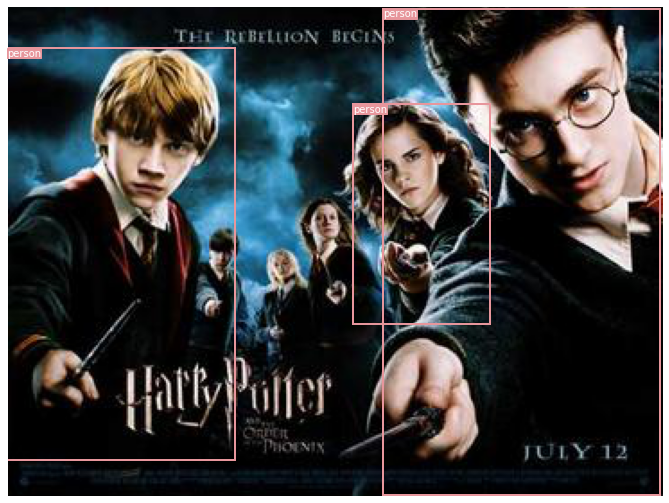

In [12]:
# Get bounding-box colors
cmap = plt.get_cmap('tab20b') # get a colormap
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
plt.show();

### Question: Test an image you will choose yourself